In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.CRITICAL)

In [3]:
import nltk
# nltk.download("stopwords")
# nltk.download("wordnet")

In [4]:
import pandas as pd
tweets_csv = pd.read_csv("data/twcs.csv")
tweets_csv.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


First I tried to analyze single tweets but it turned out to be unmanagable on my computer and also harmful since tf-idf's tf values will almost always be 1s thus rendering it worthless. So I arranged single tweets into "conversations" using <i>in_response_to_tweet_id</i> and added a <i>channel</i> column referring to the brand (Amazon, Uber, etc.). In this format 1 document is 1 conversation. Documents now have a fair chance of having a meaningful term frequency and it also reduces sample size making it possible to iterate more.

In [5]:
import numpy as np

tweets = tweets_csv.copy()

first_mask = tweets.in_response_to_tweet_id.isnull()
first_tweet_ids = tweets.loc[first_mask, "tweet_id"].values
tweet_conversation = pd.DataFrame({"tweet_id": first_tweet_ids, 
                                   "conversation_id": np.arange(first_tweet_ids.size) + 1}, 
                                  dtype="int64")

unmatched_tweets = tweets.loc[~first_mask, ["tweet_id", "in_response_to_tweet_id"]].astype("int64")

results = tweet_conversation.copy()

while not tweet_conversation.empty:
    merged = pd.merge(unmatched_tweets, tweet_conversation, how="left", left_on="in_response_to_tweet_id", right_on="tweet_id", 
                      suffixes=("", "_parent"))
    matched_mask = merged.tweet_id_parent.notnull()
    tweet_conversation = merged.loc[matched_mask, tweet_conversation.columns]
    results = results.append(tweet_conversation.copy(), ignore_index=True)
    unmatched_tweets = merged.loc[~matched_mask, unmatched_tweets.columns]

results["conversation_id"] = results.conversation_id.astype("int64")

tweets = pd.merge(tweets, results, on="tweet_id")

channels = tweets[~tweets.author_id.str.match(r"[0-9]+$")].groupby("conversation_id")["author_id"].first().to_frame("channel")
tweets = pd.merge(tweets, channels, left_on="conversation_id", right_index=True)

tweets.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,channel
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,1,sprintcare
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,1,sprintcare
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,1,sprintcare
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,1,sprintcare
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,1,sprintcare


I decided to analyze a single channel partly because of the finite amount of computational resources I have and also I found it more natural to formulate the problem this way while still working with a realistic scenario.

In [6]:
channel_name = "AskSeagate"
channel_tweets = tweets[tweets.channel == channel_name].groupby("conversation_id")["text"].apply(lambda s: s.str.cat(sep=" "))
channel_tweets.head()

conversation_id
3385     @119615 Unfortunately, the .nbi files cannot b...
15117    @132587 Hello Joey,\n\nWe are sorry that your ...
15118    @132588 Hello Krista,\n\nUnfortunately we don'...
21238    @139188 Try the number zero instead of the let...
21239    @139189 If you have come to the conclusion tha...
Name: text, dtype: object

This is the preprocessing function that does pretty standard things like stopword and url removal, lemmatization and tokenization using nltk.

In [7]:
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import re

tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
url_pattern = re.compile(r"https\:\/\/t\.co\/[a-zA-Z0-9]+")
num_pattern = re.compile(r"[0-9]+$")

def get_cleaned_doc(doc):
    cleaned = url_pattern.sub("?", doc)
    cleaned = cleaned.lower()
    cleaned = tokenizer.tokenize(cleaned)
    cleaned = [word for word in cleaned if num_pattern.match(word) is None]
    cleaned = [lemmatizer.lemmatize(word) for word in cleaned]
    cleaned = [word for word in cleaned if word not in stop]
    return cleaned


Actually converting documents and filtering (at least in 2 documents and in no more than 50% of all documents) vocabulary.

In [8]:
from collections import defaultdict
from gensim.corpora import Dictionary

docs = [get_cleaned_doc(doc) for doc in channel_tweets]

dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=2, keep_n=None)
corpus = [dictionary.doc2bow(doc) for doc in docs]

First to have an overview of the channel's content I visualized the most important words of the channel using a flattened corpus that is equivalent to term frequency weighting.

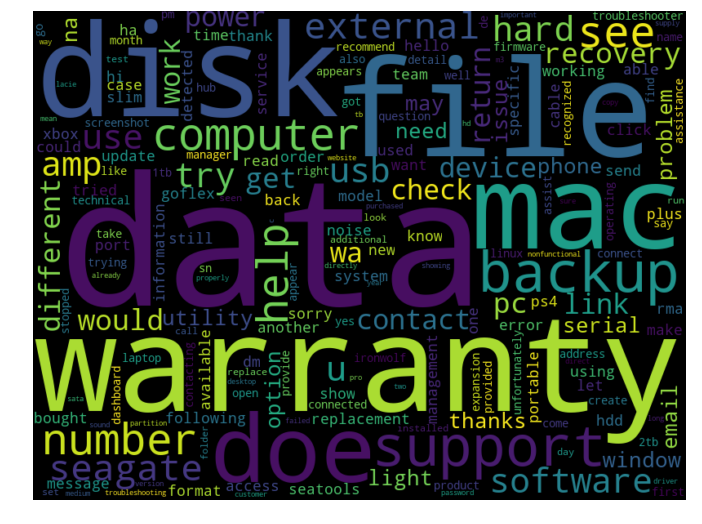

In [16]:
from gensim.models import TfidfModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt

%matplotlib inline

flattened_corpus = [dictionary.doc2bow([token for doc in docs for token in doc])]

tfidf = TfidfModel(flattened_corpus, dictionary=dictionary)
token_imp = dict([(dictionary[token_id], imp) for token_id, imp in tfidf[flattened_corpus][0]])

word_cloud = WordCloud(width=800, height=600).generate_from_frequencies(token_imp)

plt.figure(figsize=(12, 9))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off");


The I tried to identify clusters within the channel using hierarchical clustering with different metrics (cosine and euclidean), clustering methods (single, complete, average, ward) and weighting schemes (some ideas from http://brandonrose.org/clustering). I visualized the result to help select optimal number of clusters.

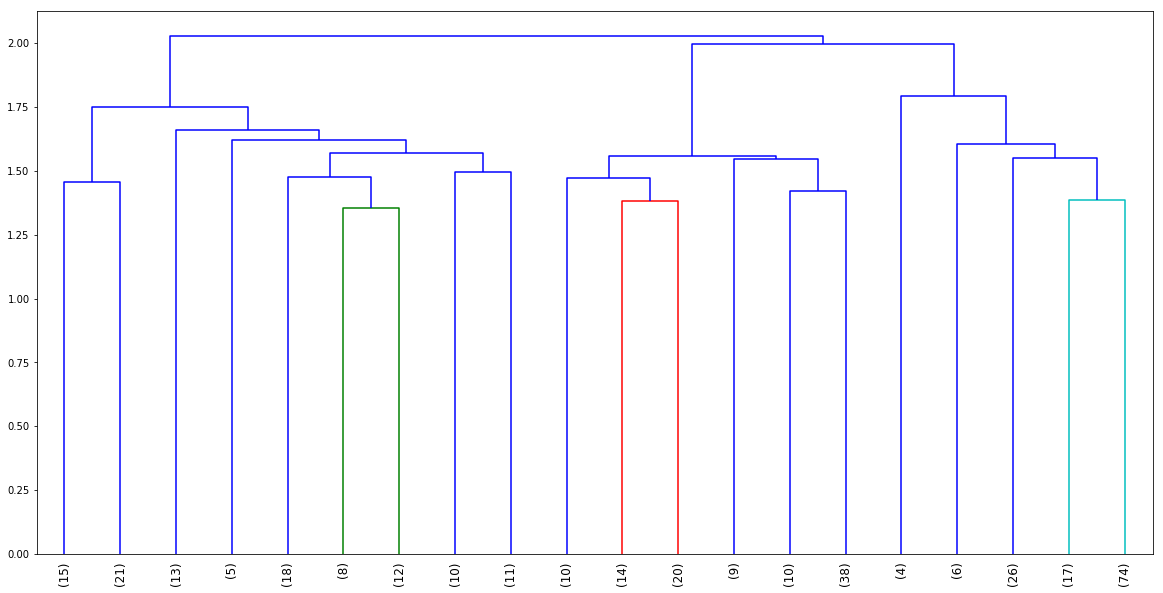

In [109]:
from gensim.matutils import corpus2dense
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, ward

weighted_corpus = TfidfModel(corpus, dictionary=dictionary, smartirs="btn")[corpus]

dense_corpus = corpus2dense(weighted_corpus, len(dictionary)).T

dist = pdist(dense_corpus, metric="cosine")

Z = linkage(dist, "ward")

plt.figure(figsize=(20, 10))
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=12.,
    truncate_mode = "lastp",
    p=20
);


After selecting the number of clusters show top n words for each

In [110]:
from scipy.cluster.hierarchy import fcluster

k = 20
clusters = fcluster(Z, k, criterion='maxclust')

clustered_docs = []

for cidx in range(k):
    cluster_indices = np.where(clusters == cidx + 1)[0]    
    clustered_docs.append([token for i, doc in enumerate(docs) if i in cluster_indices for token in doc])

clustered_dict = Dictionary(clustered_docs)
clustered_corpus = [clustered_dict.doc2bow(doc) for doc in clustered_docs]

tfidf = TfidfModel(clustered_corpus, dictionary=clustered_dict)

top_n = 5

topics = []

for cidx in range(k):
    token_imp = [(clustered_dict[token_id], imp) for token_id, imp in tfidf[clustered_corpus[cidx]]]
    token_imp.sort(key=lambda x: x[1], reverse=True)
    top_words = [token for token, imp in token_imp][:top_n]
    topics.append(top_words)

df = pd.DataFrame(topics)
df.columns.name = "word"
df.index.name = "cluster"
df


word,0,1,2,3,4
cluster,,,,,
0,recover,data,read,recovery,cost
1,cable,usb,port,nonfunctional,either
2,supply,damaged,electronics,adapter,power
3,bitlocker,light,locked,blinking,noise
4,troubleshooter,month,constitute,fanfest,died
5,serious,indicate,fall,platter,quality
6,sector,reallocated,seatools,chkdsk,copying
7,provided,based,zm,xboxsupport,xbox
8,recovery,covered,data,sierra,sooner


Showing word cloud for random cluster

Showing cluster 16


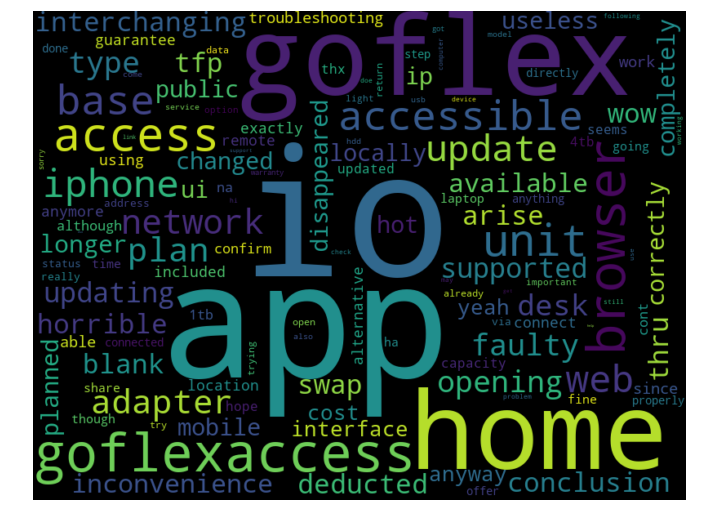

In [111]:
rnd_idx = np.random.randint(len(clustered_corpus))
print("Showing cluster " + str(rnd_idx))

token_imp = dict([(clustered_dict[token_id], imp) for token_id, imp in tfidf[clustered_corpus[rnd_idx]]])

word_cloud = WordCloud(width=800, height=600).generate_from_frequencies(token_imp)

plt.figure(figsize=(12, 9))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off");

I also tried Latent Dirichlet Allocation. Here I turned on debugging to select optimal number of iterations and passes. I use asymmetric, automatically learned priors for alpha as suggested here: https://people.cs.umass.edu/~wallach/publications/wallach09rethinking.pdf and play with different weighting schemes.

In [ ]:
from gensim.models import LdaModel

weighted_corpus = TfidfModel(corpus, dictionary=dictionary, smartirs="btn")[corpus]

logging.getLogger().setLevel(logging.DEBUG) # checking convergence
lda = LdaModel(weighted_corpus, id2word=dictionary, num_topics=10, alpha='auto', iterations=400, passes=3)
logging.getLogger().setLevel(logging.CRITICAL)

Helper function for evaluating different number of topics by perplexity and coherence using fold cross validation

In [116]:
import random
from gensim.models import LdaModel, LdaMulticore, CoherenceModel

def eval_config(corpus, texts, n_topics, k=10, iterations=100, passes=1, multicore=False):
    def get_lda_model(train_corpus):
        if multicore:
            return LdaMulticore(train_corpus, id2word=dictionary, num_topics=n_topics, iterations=iterations, passes=passes)
        return LdaModel(train_corpus, id2word=dictionary, num_topics=n_topics, alpha='auto', iterations=iterations, passes=passes)
    
    random.shuffle(corpus)
    perps = []
    for i in range(k):
        val_from = round(i / k * len(corpus)) if k > 1 else 0
        val_to = round((i + 1) / k * len(corpus)) if k > 1 else 0
        train = corpus[:val_from] + corpus[val_to:]
        val = corpus[val_from:val_to]
        
        lda = get_lda_model(train)
        perps.append(lda.log_perplexity(val if k > 1 else train))
    
    lda = get_lda_model(corpus)
    umass = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    cv = CoherenceModel(model=lda, texts=texts, coherence='c_v')
    
    return (np.mean(perps), np.std(perps), umass.get_coherence(), cv.get_coherence(), lda)

In [126]:
topic_values = [2, 5, 10, 25, 50, 100]
results = [eval_config(list(weighted_corpus), docs, n_topics, iterations=400, passes=3) for n_topics in topic_values]

df = pd.DataFrame({"n_topics": topic_values, 
                   "mean perplexity": [result[0] for result in results], 
                   "perplexity sd": [result[1] for result in results], 
                   "umass": [result[2] for result in results], 
                   "c_v": [result[3] for result in results]}, index=topic_values)

df.index.name = "n_topics"
df

c:\users\gyorgym\apps\miniconda3\envs\dl\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


,c_v,mean perplexity,n_topics,perplexity sd,umass
n_topics,,,,,
2,0.316020,-7.340301,2,0.009641,-1.381748
5,0.302614,-7.673261,5,0.083480,-1.750386
10,0.310537,-8.362895,10,0.220176,-3.790227
25,0.328001,-9.643280,25,0.096617,-7.195896
50,0.374562,-11.894719,50,0.530215,-9.691197
100,0.392771,-16.006061,100,1.236329,-9.605583


By setting relevance to a lower value we can find more relevant words for a topic (the original paper suggests somewhere around 0.6)

In [125]:
import pyLDAvis.gensim

lda = LdaModel(weighted_corpus, id2word=dictionary, num_topics=10, alpha='auto', iterations=400, passes=3)

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, weighted_corpus, dictionary, mds="tsne")

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
4      17.384193        1       1  366.467621  259.729401
3      11.878120        1       2 -137.499435 -493.890656
6      11.531359        1       3  159.544479  -98.395981
7       9.024055        1       4  271.732666 -445.473206
1       8.985098        1       5 -506.576202   23.157667
8       8.716865        1       6 -331.822235  396.340881
2       8.695332        1       7 -200.972778 -149.319244
0       8.560646        1       8  534.299622  -97.470207
9       8.058078        1       9   81.516479  531.928955
5       7.166263        1      10  -40.137253  177.144974, topic_info=     Category       Freq             Term       Total  loglift  logprob
term                                                                   
524   Default  42.000000         replaced   42.000000  30.0000  30.0000
101   Default  73.000000           goflex   73.000000  29.0000  29.0000
7     Default  50.000000           delete   50.000000  28.0000  28.0000
947   Default  26.000000            white   26.000000  27.0000  27.0000
925   Default  30.000000          suggest   30.000000  26.0000  26.0000
964   Default  30.000000             cord   30.000000  25.0000  25.0000
791   Default  44.000000        partition   44.000000  24.0000  24.0000
35    Default  97.000000         detected   97.000000  23.0000  23.0000
56    Default  66.000000               hd   66.000000  22.0000  22.0000
247   Default  63.000000           either   63.000000  21.0000  21.0000
43    Default  93.000000        operating   93.000000  20.0000  20.0000
203   Default  72.000000             year   72.000000  19.0000  19.0000
420   Default  35.000000             drop   35.000000  18.0000  18.0000
28    Default  63.000000  troubleshooting   63.000000  17.0000  17.0000
444   Default  57.000000          getting   57.000000  16.0000  16.0000
676   Default  26.000000               je   26.000000  15.0000  15.0000
687   Default  26.000000            votre   26.000000  14.0000  14.0000
674   Default  26.000000               il   26.000000  13.0000  13.0000
256   Default  75.000000       management   75.000000  12.0000  12.0000
425   Default  43.000000             kind   43.000000  11.0000  11.0000
99    Default  50.000000             fine   50.000000  10.0000  10.0000
696   Default  61.000000          storage   61.000000   9.0000   9.0000
344   Default  42.000000           supply   42.000000   8.0000   8.0000
615   Default  21.000000     goflexaccess   21.000000   7.0000   7.0000
103   Default  51.000000             home   51.000000   6.0000   6.0000
384   Default  67.000000              way   67.000000   5.0000   5.0000
678   Default  46.000000               le   46.000000   4.0000   4.0000
181   Default  30.000000            place   30.000000   3.0000   3.0000
491   Default  50.000000        apologize   50.000000   2.0000   2.0000
318   Default  30.000000               un   30.000000   1.0000   1.0000
...       ...        ...              ...         ...      ...      ...
406   Topic10  12.200229           unable   34.917622   1.5842  -5.5783
33    Topic10  16.336990              ago   57.419201   1.3788  -5.2863
626   Topic10  13.717391          nothing   43.369129   1.4847  -5.4611
61    Topic10  14.842876         purchase   53.869843   1.3467  -5.3822
247   Topic10  16.276939           either   63.426907   1.2756  -5.2900
40    Topic10  23.446556            hello  125.706871   0.9566  -4.9250
179   Topic10  14.355416             page   53.602264   1.3183  -5.4156
377   Topic10  11.980951           advice   38.971123   1.4563  -5.5964
930   Topic10  11.213381                e   34.899818   1.5004  -5.6626
178   Topic10  23.764856              may  146.648224   0.8160  -4.9115
56    Topic10  15.263680               hd   66.834213   1.1590  -5.3542
26    Topic10  16.190498        technical   75.345840   1.0981  -5.2953
176   Topic10  14.514